In this worksheet, I will use Air Quality Data Set from https://archive.ics.uci.edu/ml/datasets/Air+Quality
I applied regression to this data set.
I wrote the report on this notebook.
なお、今回使用したデータは事前にNaNデータを除外したものを利用している。

-データについての解説-
このCSVファイルには15列の変数からなるデータが格納されている。具体的には、
0. Date (DD/MM/YYYY)
1. Time (HH.MM.SS)
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. True hourly averaged NOx concentration in ppb (reference analyzer)
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. Temperature in Â°C
13. Relative Humidity (%)
14. AH Absolute Humidity
である。これらのデータはイタリアの汚染度の高い地域の道路に設置されたセンサーから得られた時系列データである。

本レポートでは、PT08.S1 - PT08.S4(index:3, 6, 8, 10)と、Temperature(12), Humidity(14)を用いて、PT08.S5(11)の値を推測する回帰タスクを実装する。

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [100]:
df = pd.read_excel("AirQualityUCI.xlsx")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


まず、余計な変数を削減する。
1. DateならびにTimeは、適切な前処理を行うことができれば有用なパラメタであると予測されるが、難しいため削除する。
2. GTデータを基にPT08データが生成されるため、GTとPT08が併存してしまうと、適切な回帰が行えないと考えられるため削除
3. 同様に、相対湿度も絶対湿度と併存できないため削除

In [101]:
X = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'T', 'RH', 'AH']]
Y = df[['PT08.S5(O3)']]
print(X.shape, Y.shape)

(7344, 7) (7344, 1)


In [102]:
slice = pd.DataFrame({
    'append':[1]*7344
}
)
X = pd.concat([slice, X], axis=1)
print(X.shape, Y.shape)

(7344, 8) (7344, 1)


まずは、trainデータを基に、線形重回帰分析を行う。
これは、Y = Xb + errorであらわされるようなmodelである。
error = Y - Xb
とかきかえ、errorのL2ノルムをbで偏微分することで、最尤パラメタとして、
b = (X'X)^-1 X'Yが求まる。

このパラメタbを用いて重回帰を行うことができる。

In [103]:
def weight(X, Y):
    temp = np.linalg.inv(np.dot(X.T, X))
    temp1 = np.dot(temp, X.T)
    b = np.dot(temp1, Y)
    return b

In [104]:
r = weight(X, Y)
print(r)
print(np.dot(X, r)- Y)

[[-1.27888120e+02]
 [ 7.21676735e-01]
 [ 8.86487535e-01]
 [-1.90664276e-01]
 [-1.82306553e-01]
 [-7.94907139e+00]
 [-4.05015039e-03]
 [ 9.37519828e+01]]
      PT08.S5(O3)
0      -34.201269
1      132.960128
2      117.307112
3       -8.720292
4      -95.384186
...           ...
7339  -387.739457
7340  -119.692725
7341    51.102393
7342   176.745597
7343   247.331082

[7344 rows x 1 columns]


予測と実際の値の差を見ると、あまり良い予測を与えていないことがわかる。そこで、予測に用いるパラメータを2個まで減らしてみる。

In [105]:
X1 = df[['PT08.S1(CO)', 'RH']]
X1 = pd.concat([slice, X1], axis=1)
Y1 = df[['PT08.S5(O3)']]


In [114]:
r = weight(X1, Y1)
print(np.dot(X1, r) - Y1)


      PT08.S5(O3)
0      190.349259
1      372.583291
2      455.667168
3      284.816942
4      206.380958
...           ...
7339  -354.533651
7340  -149.335114
7341    -8.548472
7342    80.040610
7343   146.994337

[7344 rows x 1 columns]


三次元空間上でプロットすると、以下のようになる。

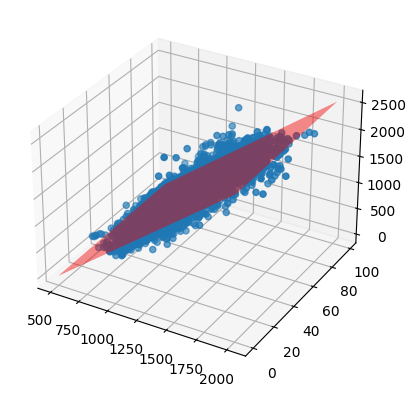

In [116]:
import matplotlib.pyplot as plt
import numpy as np

x = X1[['PT08.S1(CO)']]
y = X1[['RH']]
z = Y1[['PT08.S5(O3)']]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

x_range = np.arange(500, 2000, 1)
y_range = np.arange(0,100,1)
xx1, xx2 = np.meshgrid(x_range, y_range)
yy = (r[0] + r[1] * xx1 + r[2] * xx2) 
ax.plot_surface(xx1, xx2, yy, color='red', alpha=0.5)

plt.show()
